In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

import spacy

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

from bs4 import BeautifulSoup

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def polarity(text):
    text = TextBlob(text)
    return text.sentiment.polarity

## Notebook Contents
---
** [Word Frequency by Genre](#frequency)**  
** [Sentiment Analysis](#sentiment)**

## Data Exploration

In [3]:
#read in csv
book_info45 = pd.read_csv("book_info45.csv")
book_list45 = pd.read_csv("book_list45.csv")

#concatonate the scraped data with the original book list
df = pd.concat([book_list45, book_info45], axis = 1)

#drop all null genre & description values - lose 521 rows
df.dropna(subset=['genre','description'],inplace=True)

#clean the numeric columns
#round the average ratings to create easy to understand groupings
df.avg_rating = [float(x) for x in df.avg_rating]
df.avg_rating=[(round(x*8))/8 for x in df.avg_rating]
df.description = [BeautifulSoup(x, 'lxml').get_text() for x in df.description ]

genre_dict = {"Womens Fiction":"Fiction", "Adult Fiction":"Fiction","New Adult":"Fiction", 
              "Short Stories":"Fiction", "Asian Literature":"Fiction","Literature":"Classics",
             "Adult":"Fiction","Contemporary":"Fiction","Cultural":"Fiction","Realistic Fiction":"Young Adult",
              "Paranormal":"Horror", "Sequential Art":"Graphic Novel","Science Fiction Fantasy":"Fantasy",
              "Drama":"Plays","Historical":"Historical Fiction", "Thriller":"Mystery", "Christian":"Spirituality",
             "Marriage":"Self Help", "Autobiography":"Biography"}
df.genre.replace(genre_dict, inplace=True)

df = df[(df.genre.isin(["Young Adult", "Classics",'Fiction',"Nonfiction","Fantasy","Mystery","Romance",
                  "Childrens","Historical","Science Fiction","Horror"]))]

le = LabelEncoder()
le.fit(df['genre'])
df['genre_code']=le.transform(df['genre'])

genre_codes = df.groupby(['genre','genre_code']).count()
genre_codes = genre_codes.reset_index()[['genre','genre_code','avg_rating']]
print('Genre Codes Dictionary')
genre_codes

Genre Codes Dictionary


,genre,genre_code,avg_rating
0,Childrens,0,136
1,Classics,1,251
2,Fantasy,2,519
3,Fiction,3,909
4,Horror,4,154
5,Mystery,5,296
6,Nonfiction,6,281
7,Romance,7,181
8,Science Fiction,8,153
9,Young Adult,9,348


<a id='frequency'></a>
# TFIDF Vectorizer and Count Vectorizer Word Frequency by Genre

Below is a visual representations of the word frequency for the top 20 Count Vectorizer & TFIDF Vectorizer words for each genre. Use the plots to determine common words that are found to understand the misclassifications in the model.

For the TFIDF vectorizer, the word **dark** occurs within the top 20 words for _Romance_, _Mystery_, and _Young Adult_. Both TFIDF and Count Vectorizer cannot account for context only word frequency. A "tall, **dark**, and handsome stranger" is different from a "**dark** and stormy night". 

Next steps for this project may be to use Count2Vec to apply context to each word and decrease misclassifications.

In [4]:
X = df['description']
X.dropna(inplace=True)

cv = CountVectorizer(stop_words='english')
cv.fit_transform(X);

tv = TfidfVectorizer(stop_words='english')
tv.fit_transform(X);

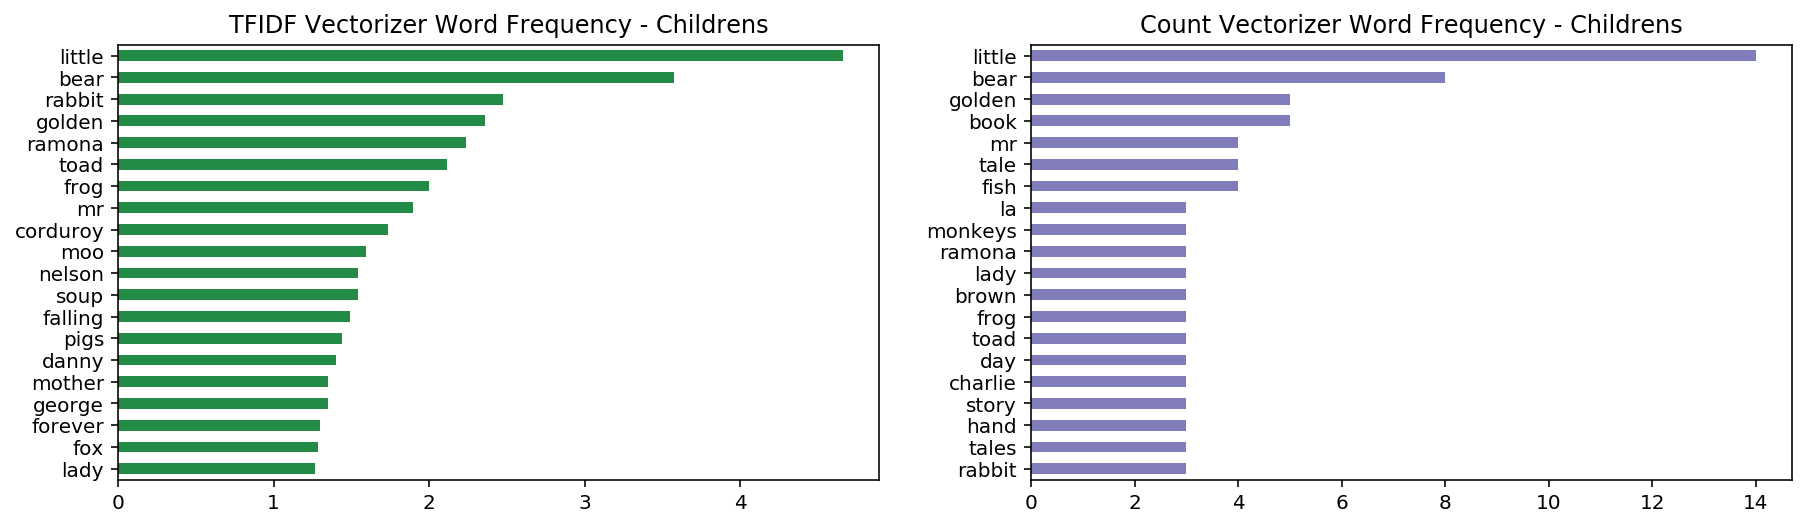

In [5]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
X = df.loc[df['genre_code'] == 0].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Childrens')

plt.subplot(1, 2, 2)
X = df.loc[df['genre_code'] == 0].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Childrens');

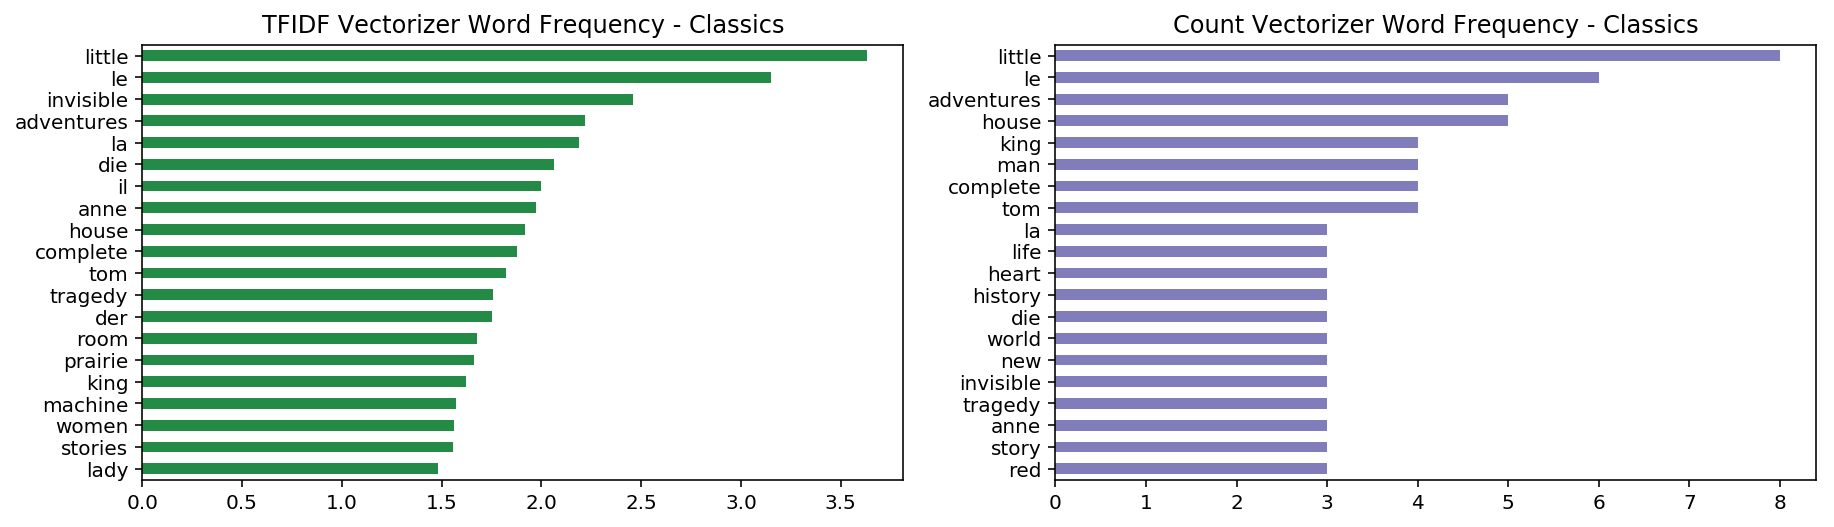

In [6]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
X = df.loc[df['genre_code'] == 1].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Classics')

plt.subplot(1,2, 2)
X = df.loc[df['genre_code'] == 1].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Classics');

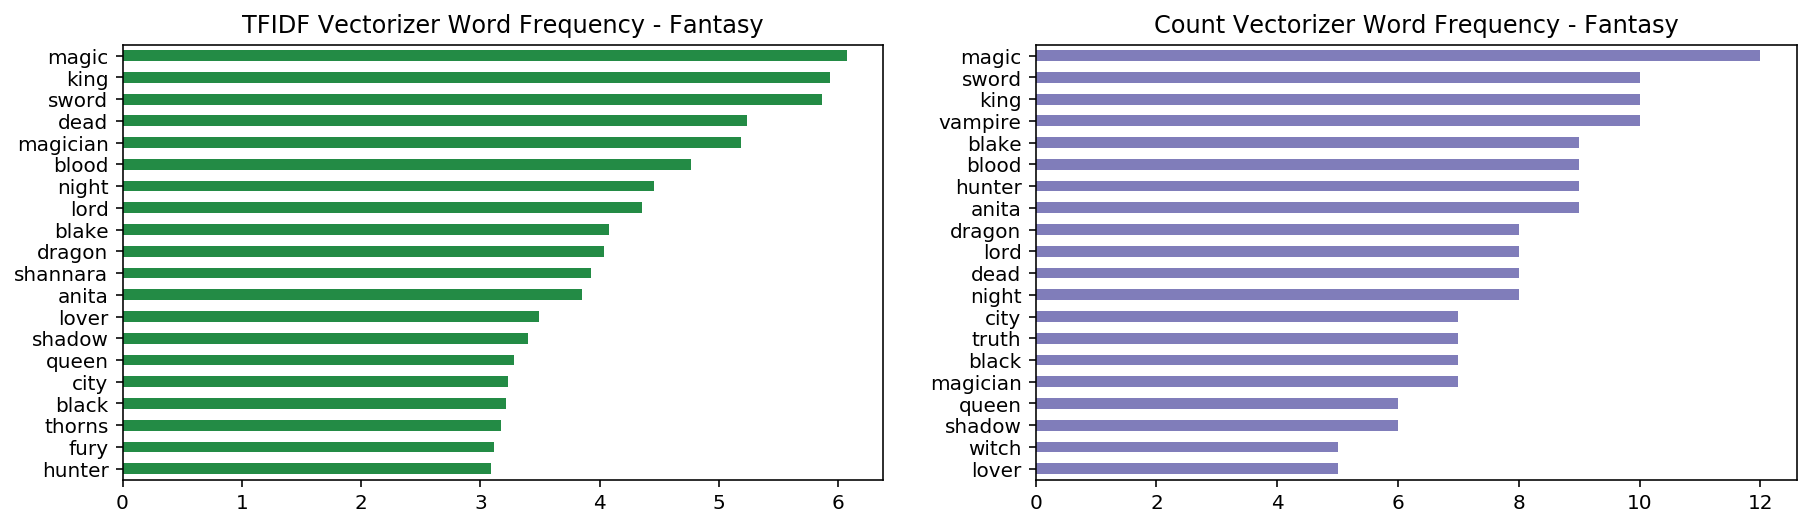

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
X = df.loc[df['genre_code'] == 2].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Fantasy')

plt.subplot(1,2, 2)
X = df.loc[df['genre_code'] == 2].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Fantasy');

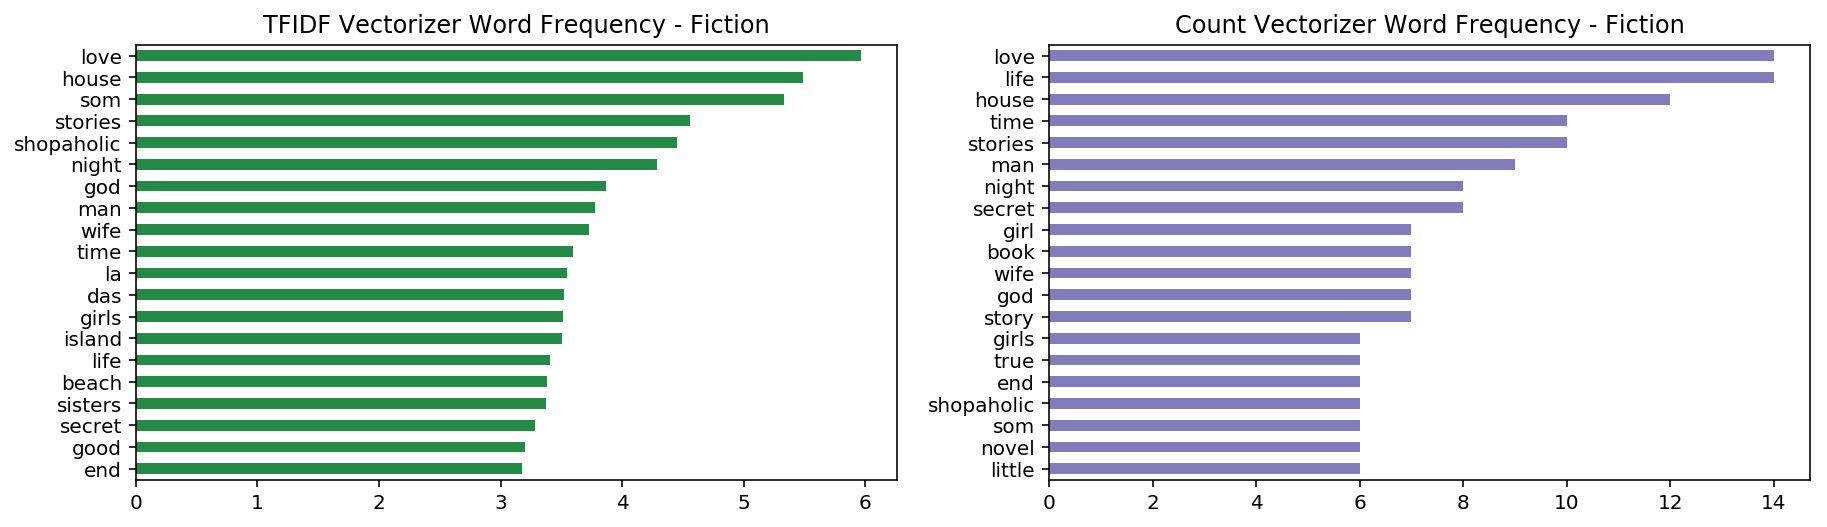

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 3].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Fiction')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 3].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Fiction');

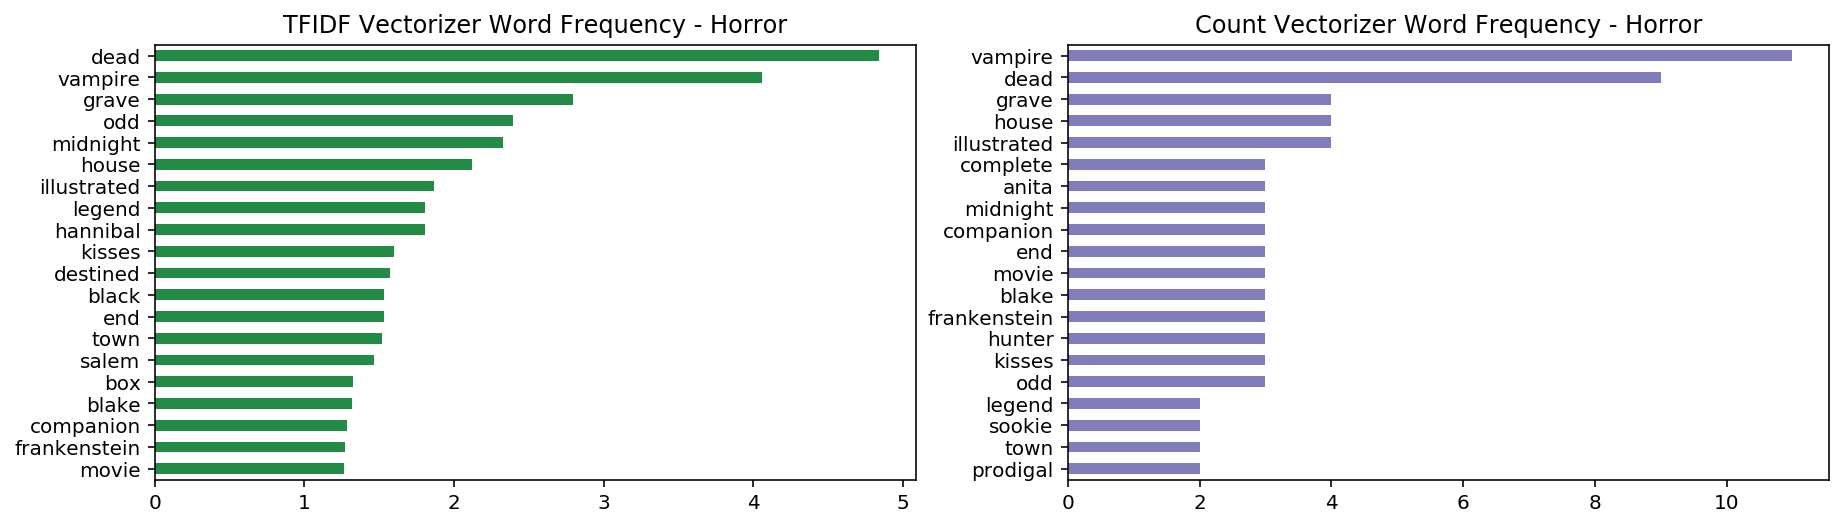

In [9]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 4].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Horror')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 4].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Horror');

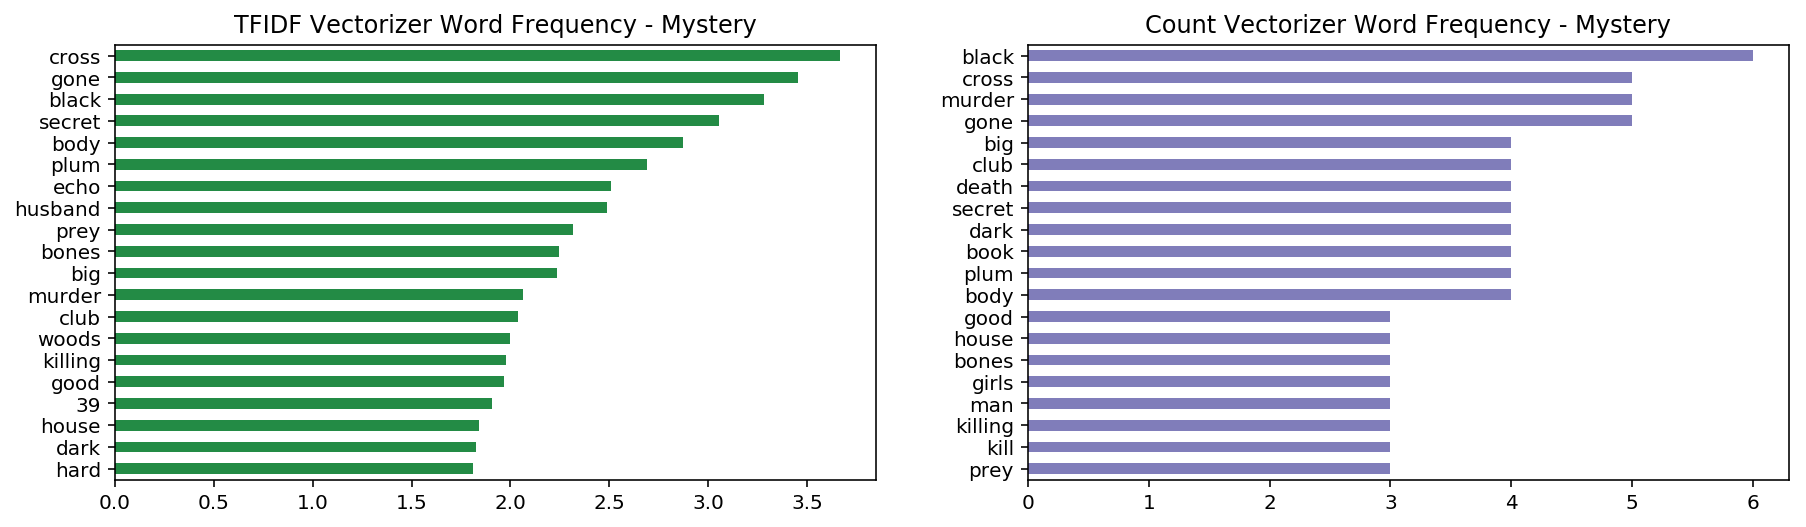

In [10]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 5].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Mystery')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 5].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Mystery');

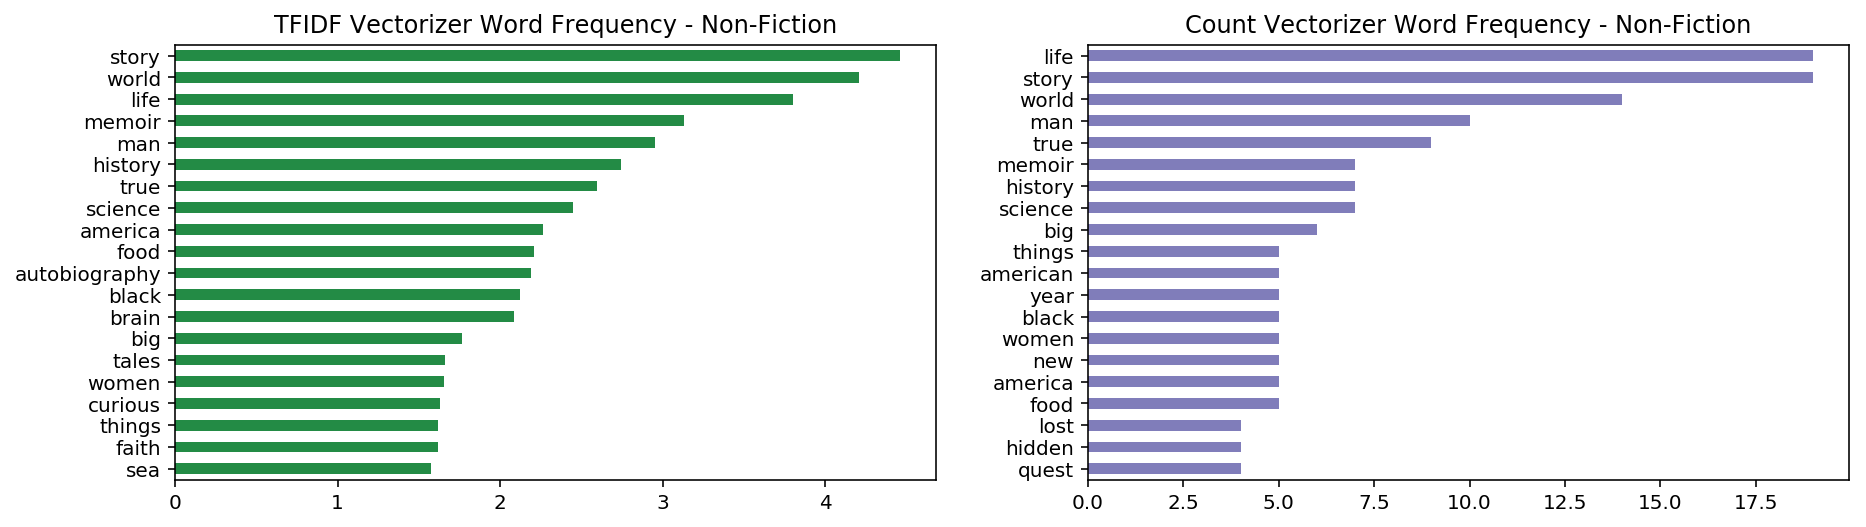

In [11]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 6].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Non-Fiction')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 6].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Non-Fiction');

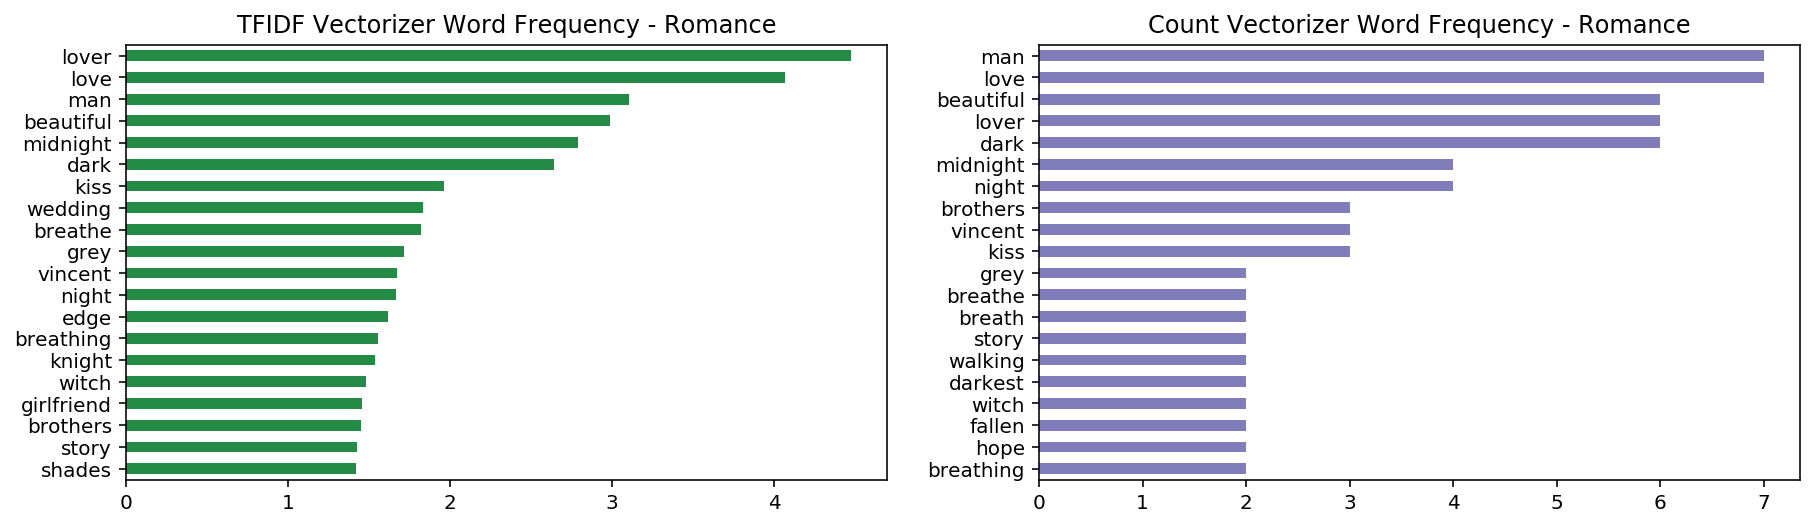

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 7].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Romance')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 7].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Romance');

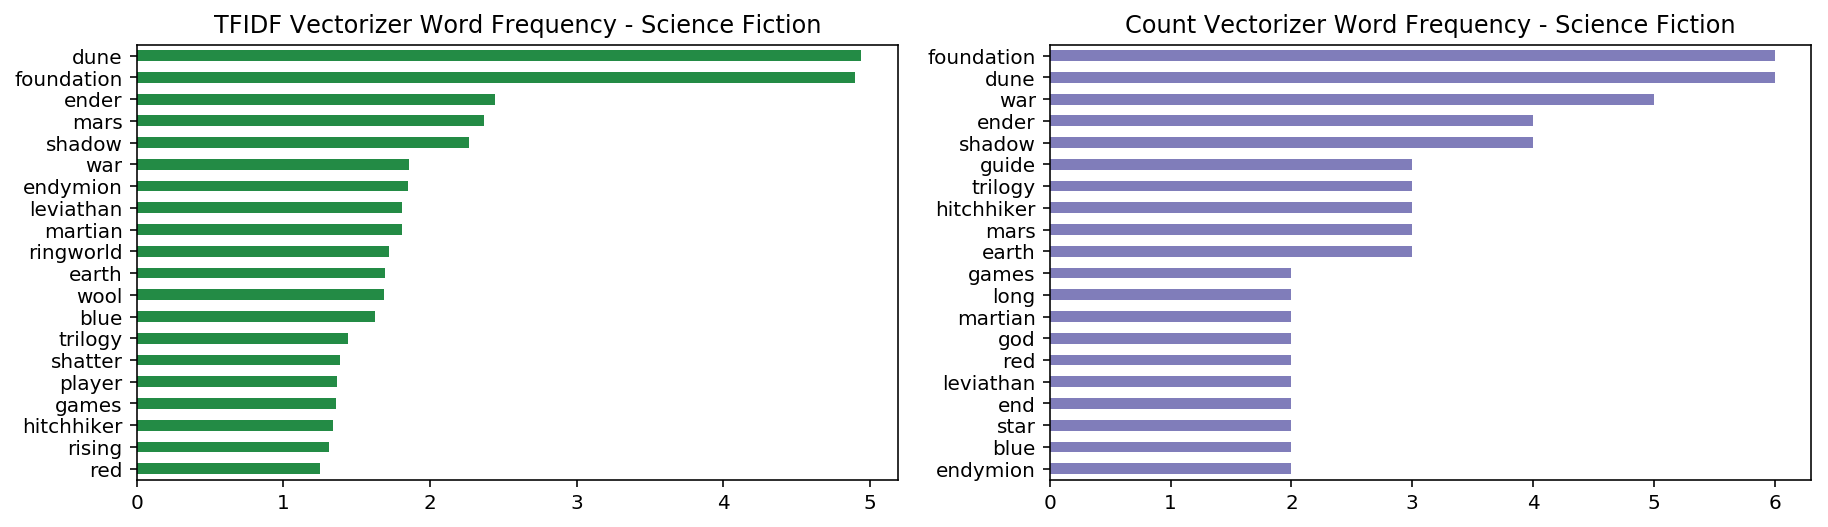

In [13]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 8].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Science Fiction')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 8].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Science Fiction');

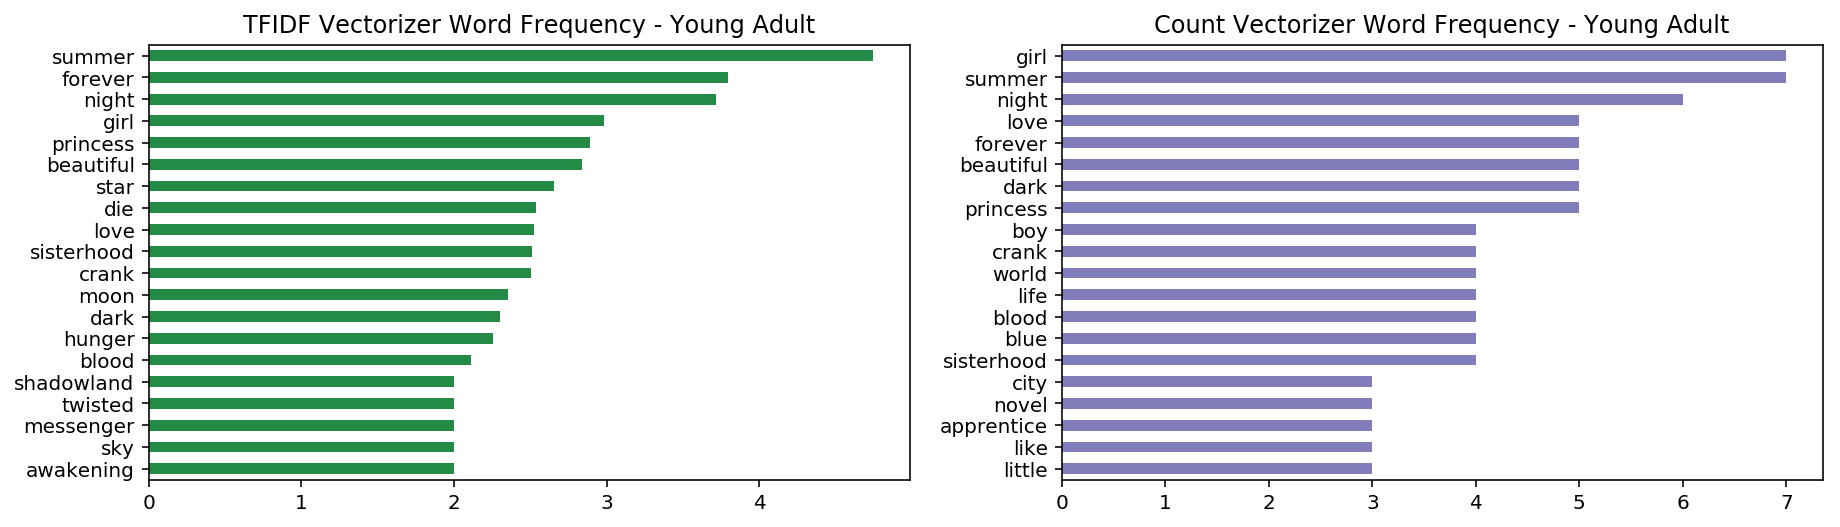

In [14]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
X = df.loc[df['genre_code'] == 9].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(tv.transform(X).todense(),columns=tv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#238b45')
plt.title('TFIDF Vectorizer Word Frequency - Young Adult')

plt.subplot(1,2,2)
X = df.loc[df['genre_code'] == 9].title.copy()
X.dropna(inplace=True)
count = pd.DataFrame(cv.transform(X).todense(),columns=cv.get_feature_names())
count.sum().sort_values(ascending=True)[-20:].plot(kind='barh', color='#807dba')
plt.title('Count Vectorizer Word Frequency - Young Adult');

<a id='sentiment'></a>
# Sentiment Analysis

In [15]:
df['polarity'] = df['description'].apply(polarity)

In [16]:
avg = df.avg_rating.mean()
childrens = df[df['genre_code'] == 0].avg_rating.mean()
classics = df[df['genre_code'] == 1].avg_rating.mean()
fantasy = df[df['genre_code'] == 2].avg_rating.mean()
fiction = df[df['genre_code'] == 3].avg_rating.mean()
horror = df[df['genre_code'] == 4].avg_rating.mean()
mystery = df[df['genre_code'] == 5].avg_rating.mean()
nonfiction = df[df['genre_code'] == 6].avg_rating.mean()
romance = df[df['genre_code'] == 7].avg_rating.mean()
sci_fi = df[df['genre_code'] == 8].avg_rating.mean()
ya= df[df['genre_code'] == 9].avg_rating.mean()

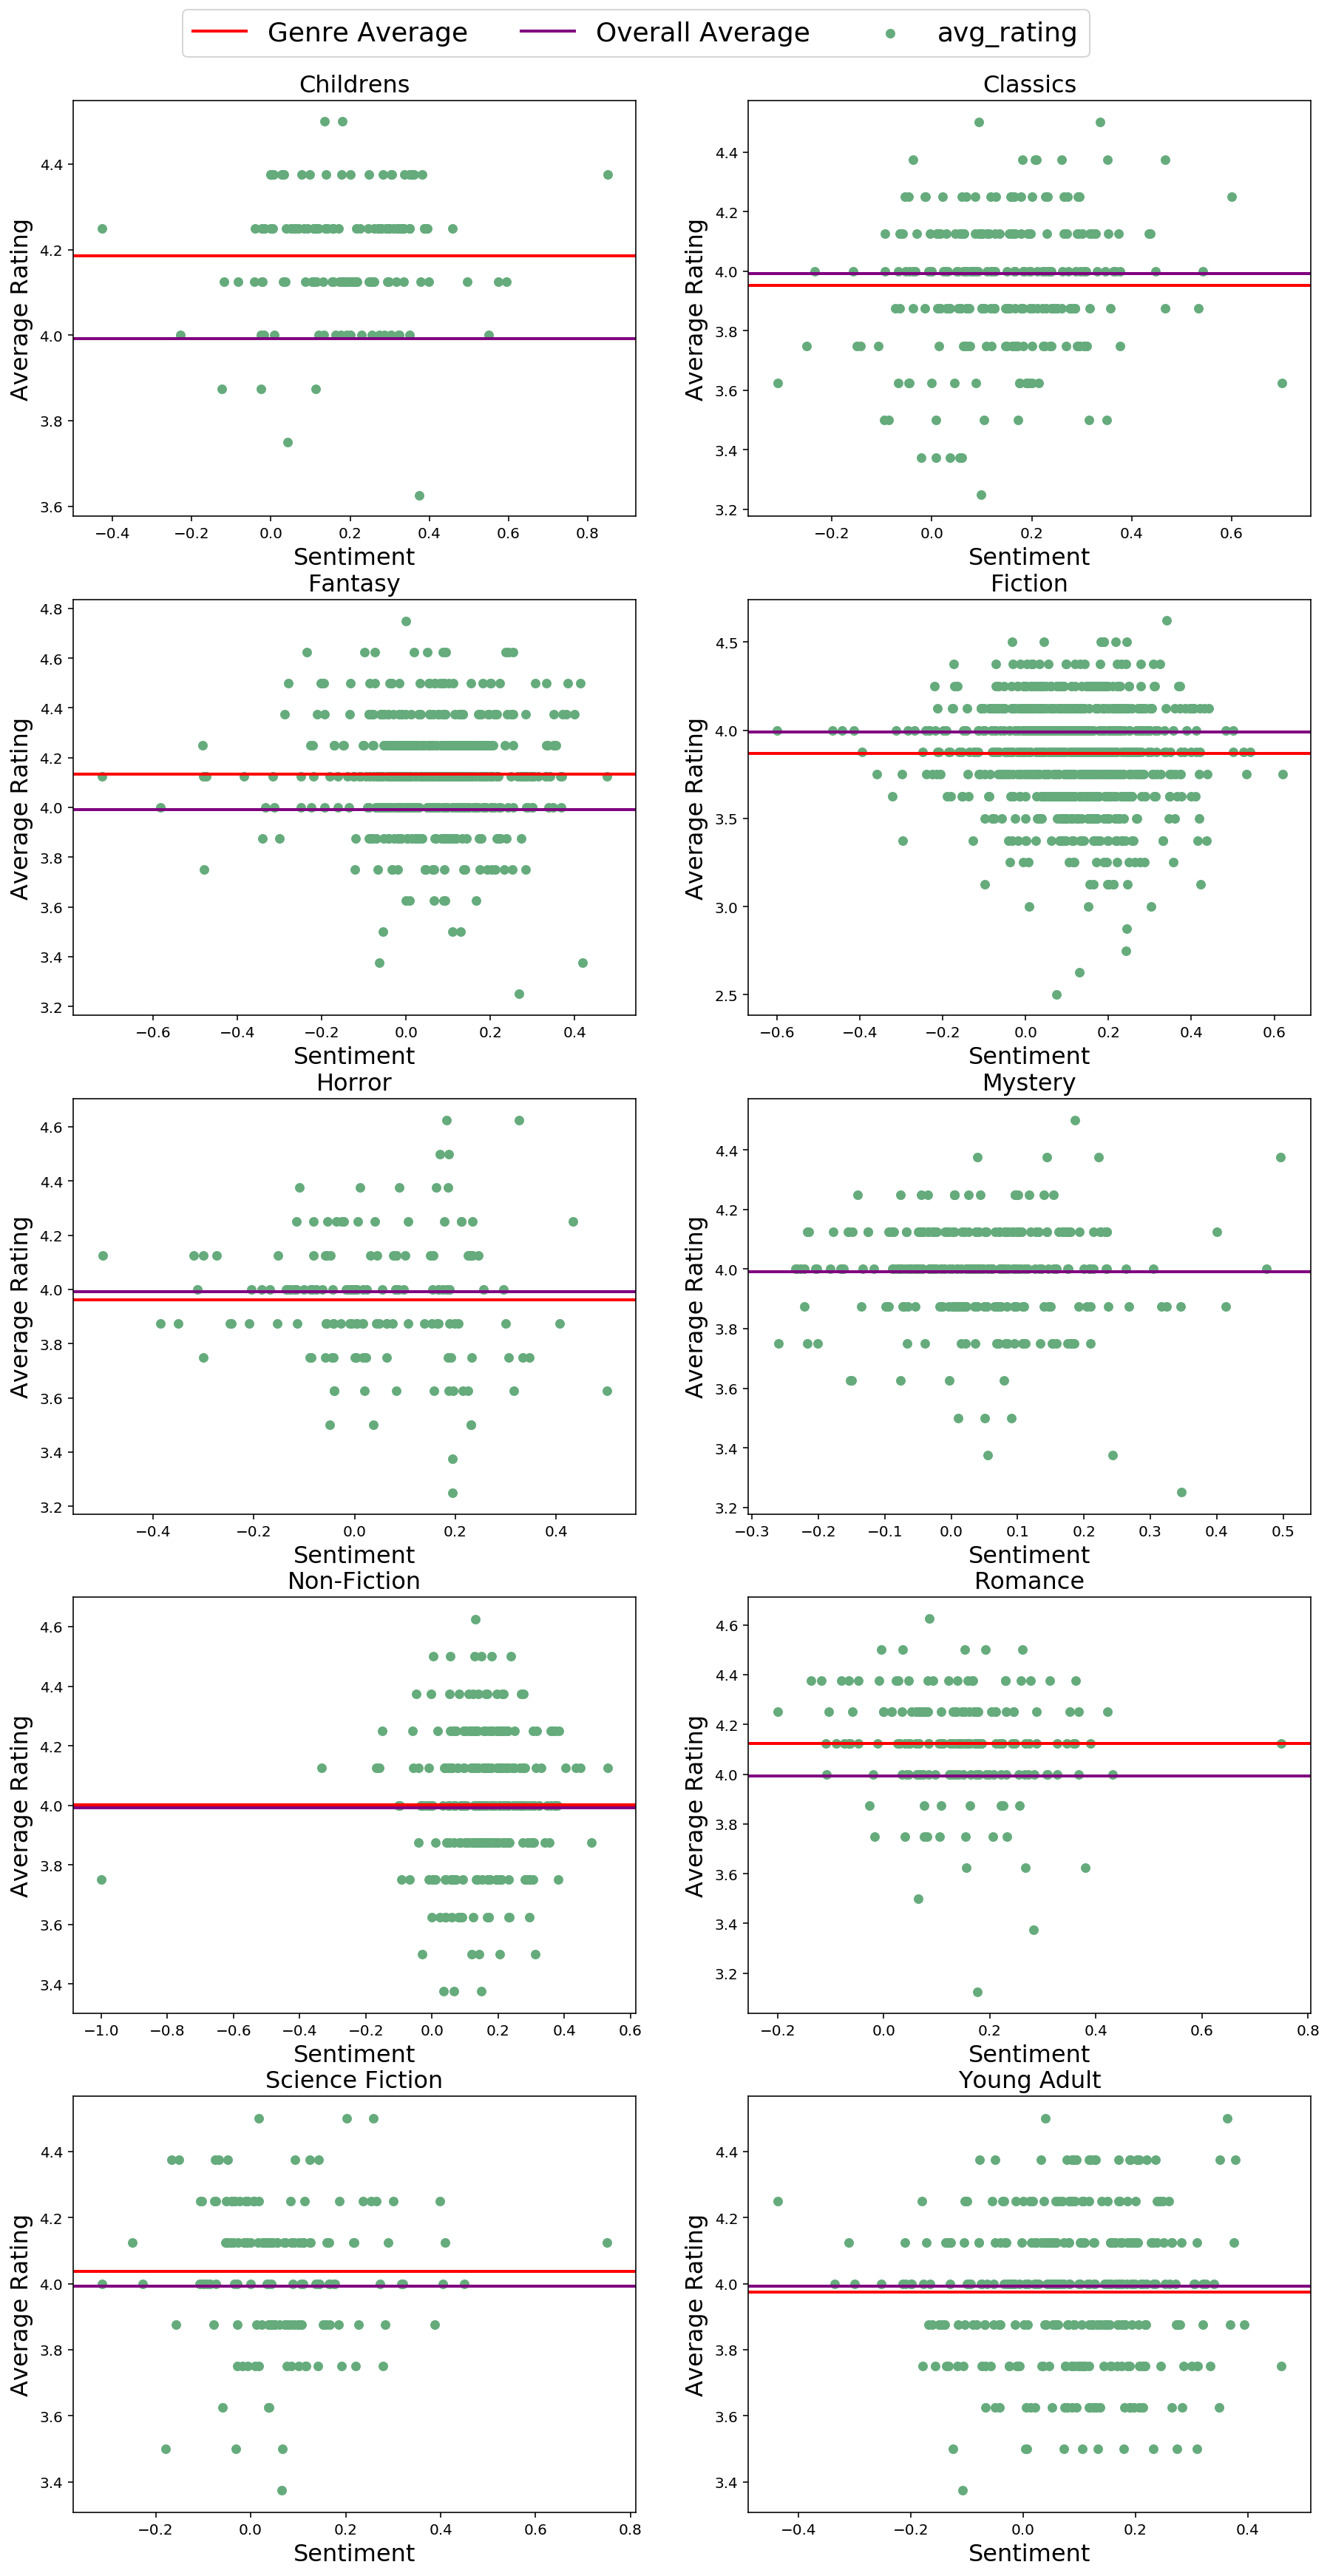

In [17]:
plt.figure(figsize=(15,30))

plt.subplot(5,2,1)
plt.axhline(y=childrens, c='red', lw=2, label = 'Genre Average')
plt.axhline(y=avg, color='purple',lw=2, label='Overall Average')
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Childrens", fontsize=16)
plt.scatter('polarity','avg_rating',data=df.loc[df['genre']=='Childrens'], s=30,color='xkcd:tea')
plt.legend(loc=9, ncol=3, fontsize=18,bbox_to_anchor=(1, 1.25))

plt.subplot(5,2,2)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Classics'],s=30, color='xkcd:tea')
plt.axhline(y=classics, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Classics", fontsize=16)

plt.subplot(5,2,3)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Fantasy'], s=30, color='xkcd:tea')
plt.axhline(y=fantasy, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Fantasy", fontsize=16)

plt.subplot(5,2,4)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Fiction'],s=30, color='xkcd:tea')
plt.axhline(y=fiction, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Fiction", fontsize=16)

plt.subplot(5,2,5)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Horror'],s=30, color='xkcd:tea')
plt.axhline(y=horror, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Horror", fontsize=16)

plt.subplot(5,2,6)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Mystery'],s=30, color='xkcd:tea')
plt.axhline(y=mystery, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Mystery", fontsize=16)

plt.subplot(5,2,7)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Nonfiction'],s=30, color='xkcd:tea')
plt.axhline(y=nonfiction, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Non-Fiction", fontsize=16)

plt.subplot(5,2,8)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Romance'],s=30, color='xkcd:tea')
plt.axhline(y=romance, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Romance", fontsize=16)

plt.subplot(5,2,9)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Science Fiction'],s=30, color='xkcd:tea')
plt.axhline(y=sci_fi, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Science Fiction", fontsize=16)

plt.subplot(5,2,10)
plt.scatter('polarity','avg_rating', data=df.loc[df['genre']=='Young Adult'],s=30, color='xkcd:tea')
plt.axhline(y=ya, c='red',lw=2)
plt.axhline(y=avg, color='purple',lw=2)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Average Rating", fontsize=16)
plt.title("Young Adult", fontsize=16);